In [1]:
!pip install resampy

In [2]:
import librosa
import librosa.display
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout

from keras.utils import np_utils
from sklearn.metrics import accuracy_score

In [3]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2023-07-13 10:06:59--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz           5%[>                   ] 289.32M  2.58MB/s    eta 37m 29s^C
^C


In [4]:
!cat UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

In [5]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [6]:
df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav


In [7]:
appended = []
for i in range(1,11):
    appended.append(df[df.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,jackhammer,dog_bark,children_playing,street_music,air_conditioner,drilling,engine_idling,siren,car_horn,gun_shot
0,fold1,120,100,100,100,100,100,96,86,36,35
1,fold2,120,100,100,100,100,100,100,91,42,35
2,fold3,120,100,100,100,100,100,107,119,43,36
3,fold4,120,100,100,100,100,100,107,166,59,38
4,fold5,120,100,100,100,100,100,107,71,98,40
5,fold6,68,100,100,100,100,100,107,74,28,46
6,fold7,76,100,100,100,100,100,106,77,28,51
7,fold8,78,100,100,100,100,100,88,80,30,30
8,fold9,82,100,100,100,100,100,89,82,32,31
9,fold10,96,100,100,100,100,100,93,83,33,32


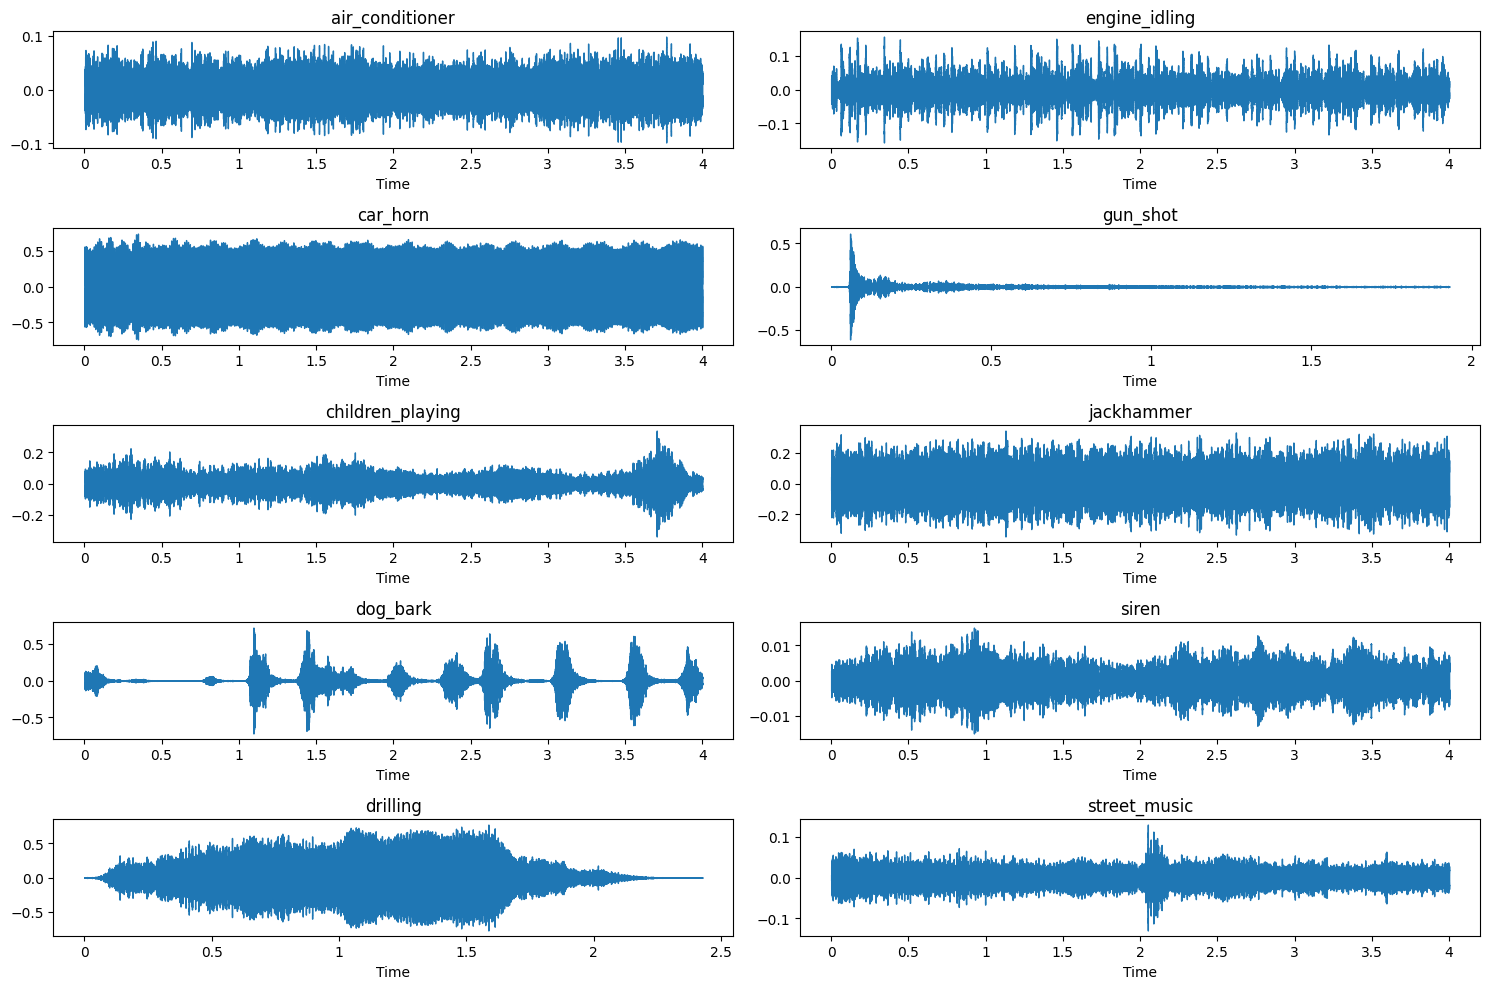

In [8]:
# Randomly select one sample of each class
random_samples = df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15,10))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

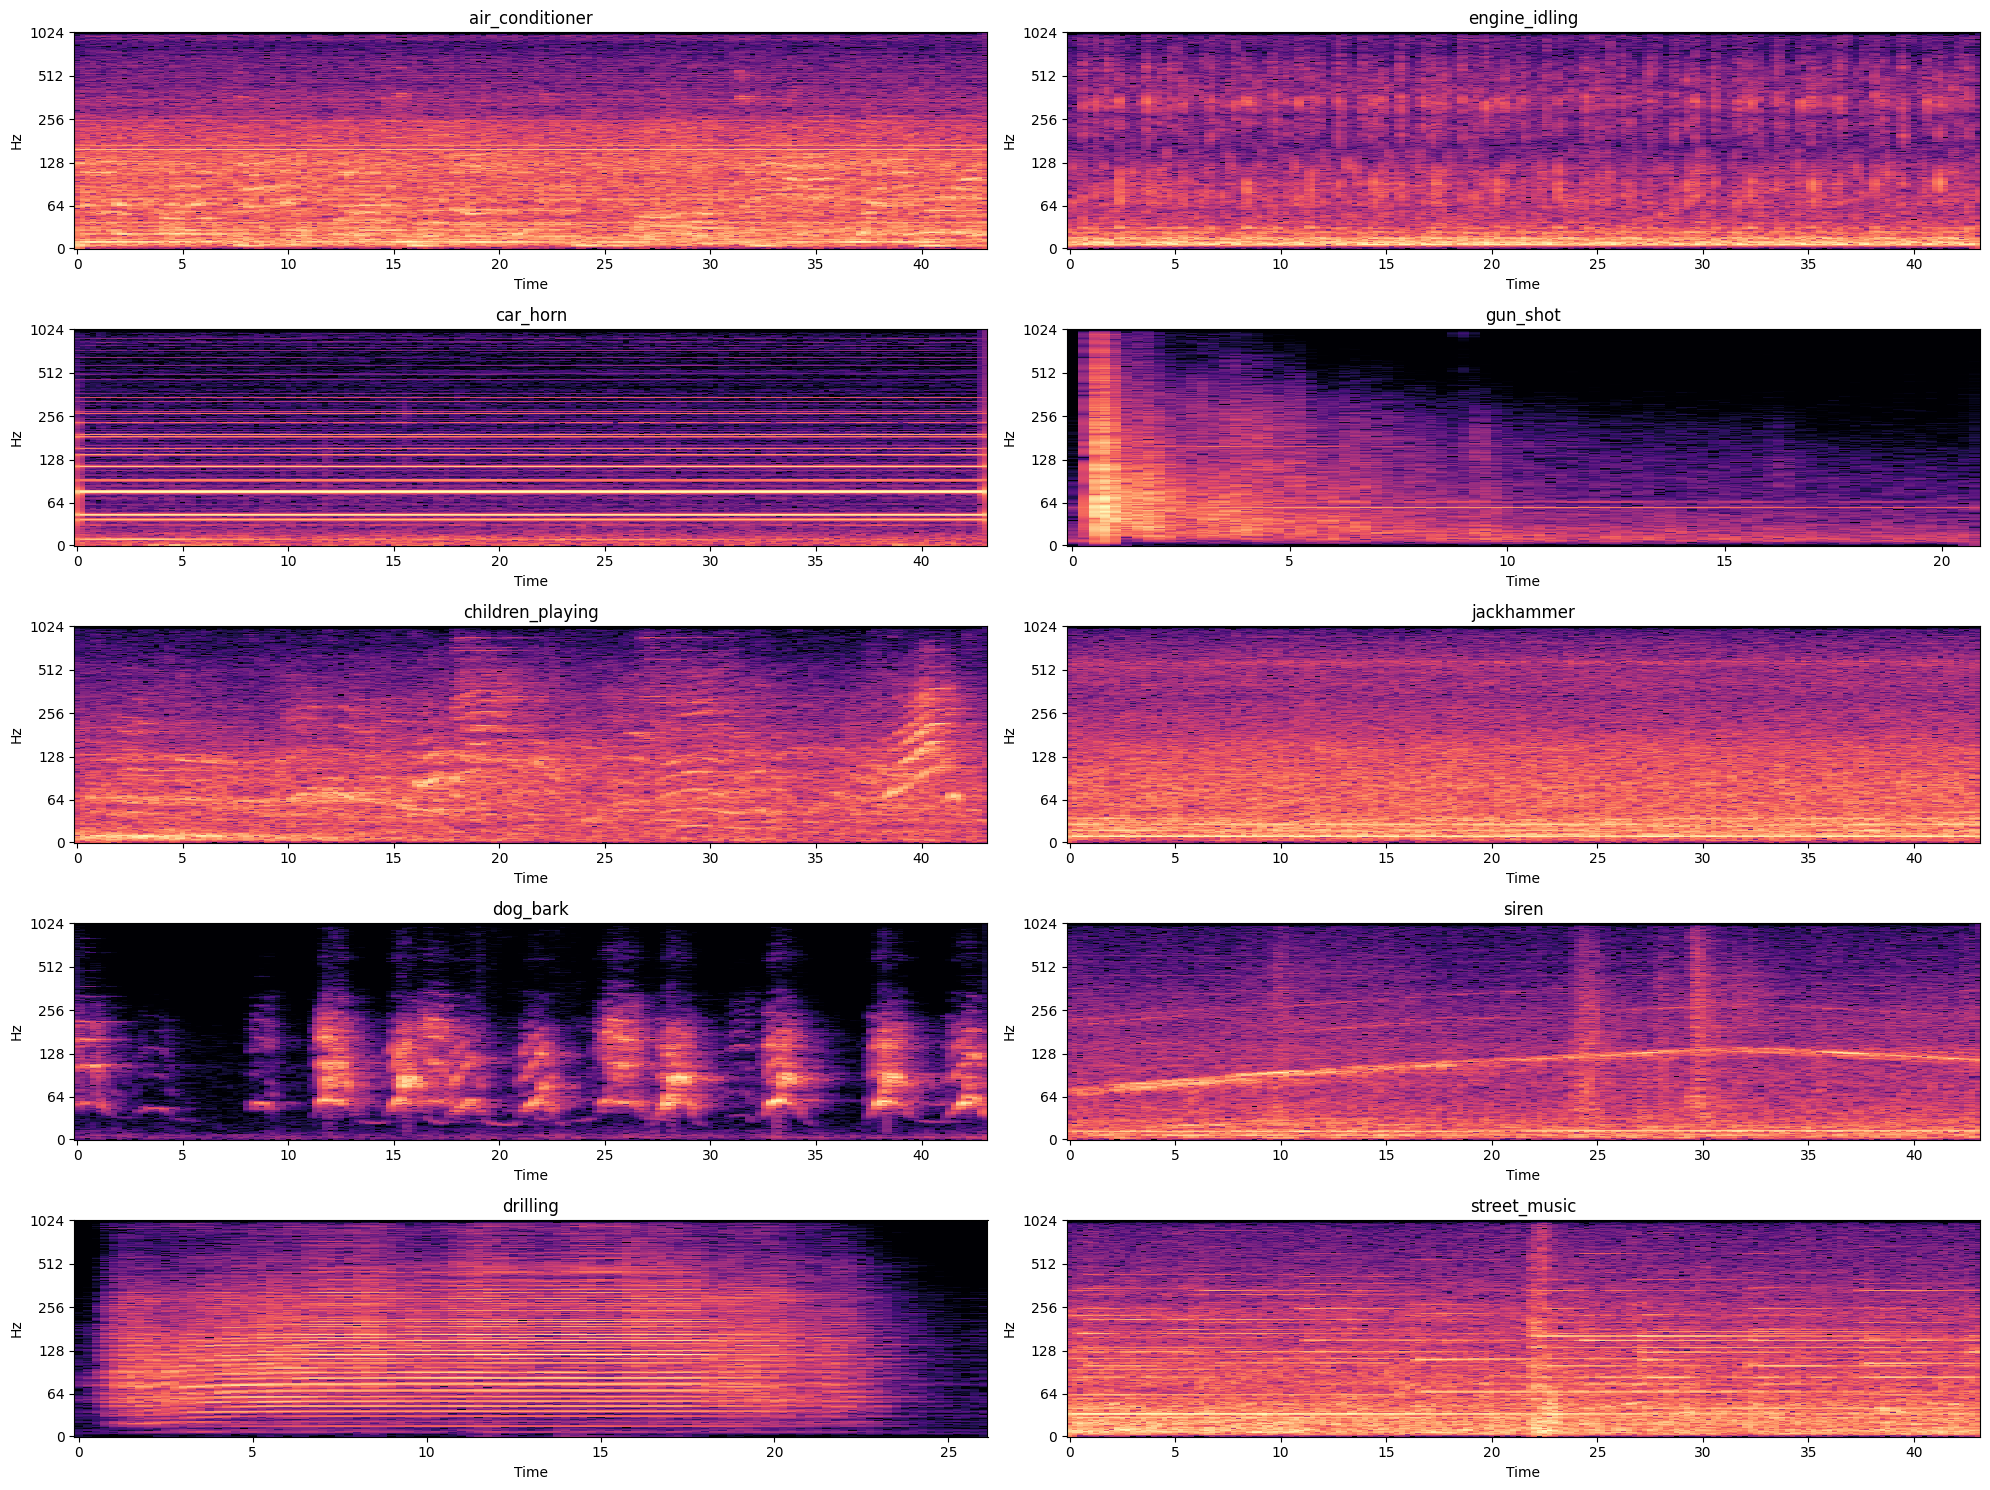

In [9]:
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,15))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(y=audio_file, n_fft=n_fft, hop_length=hop_length)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(S_db,
                             sr=n_fft,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis='log',
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

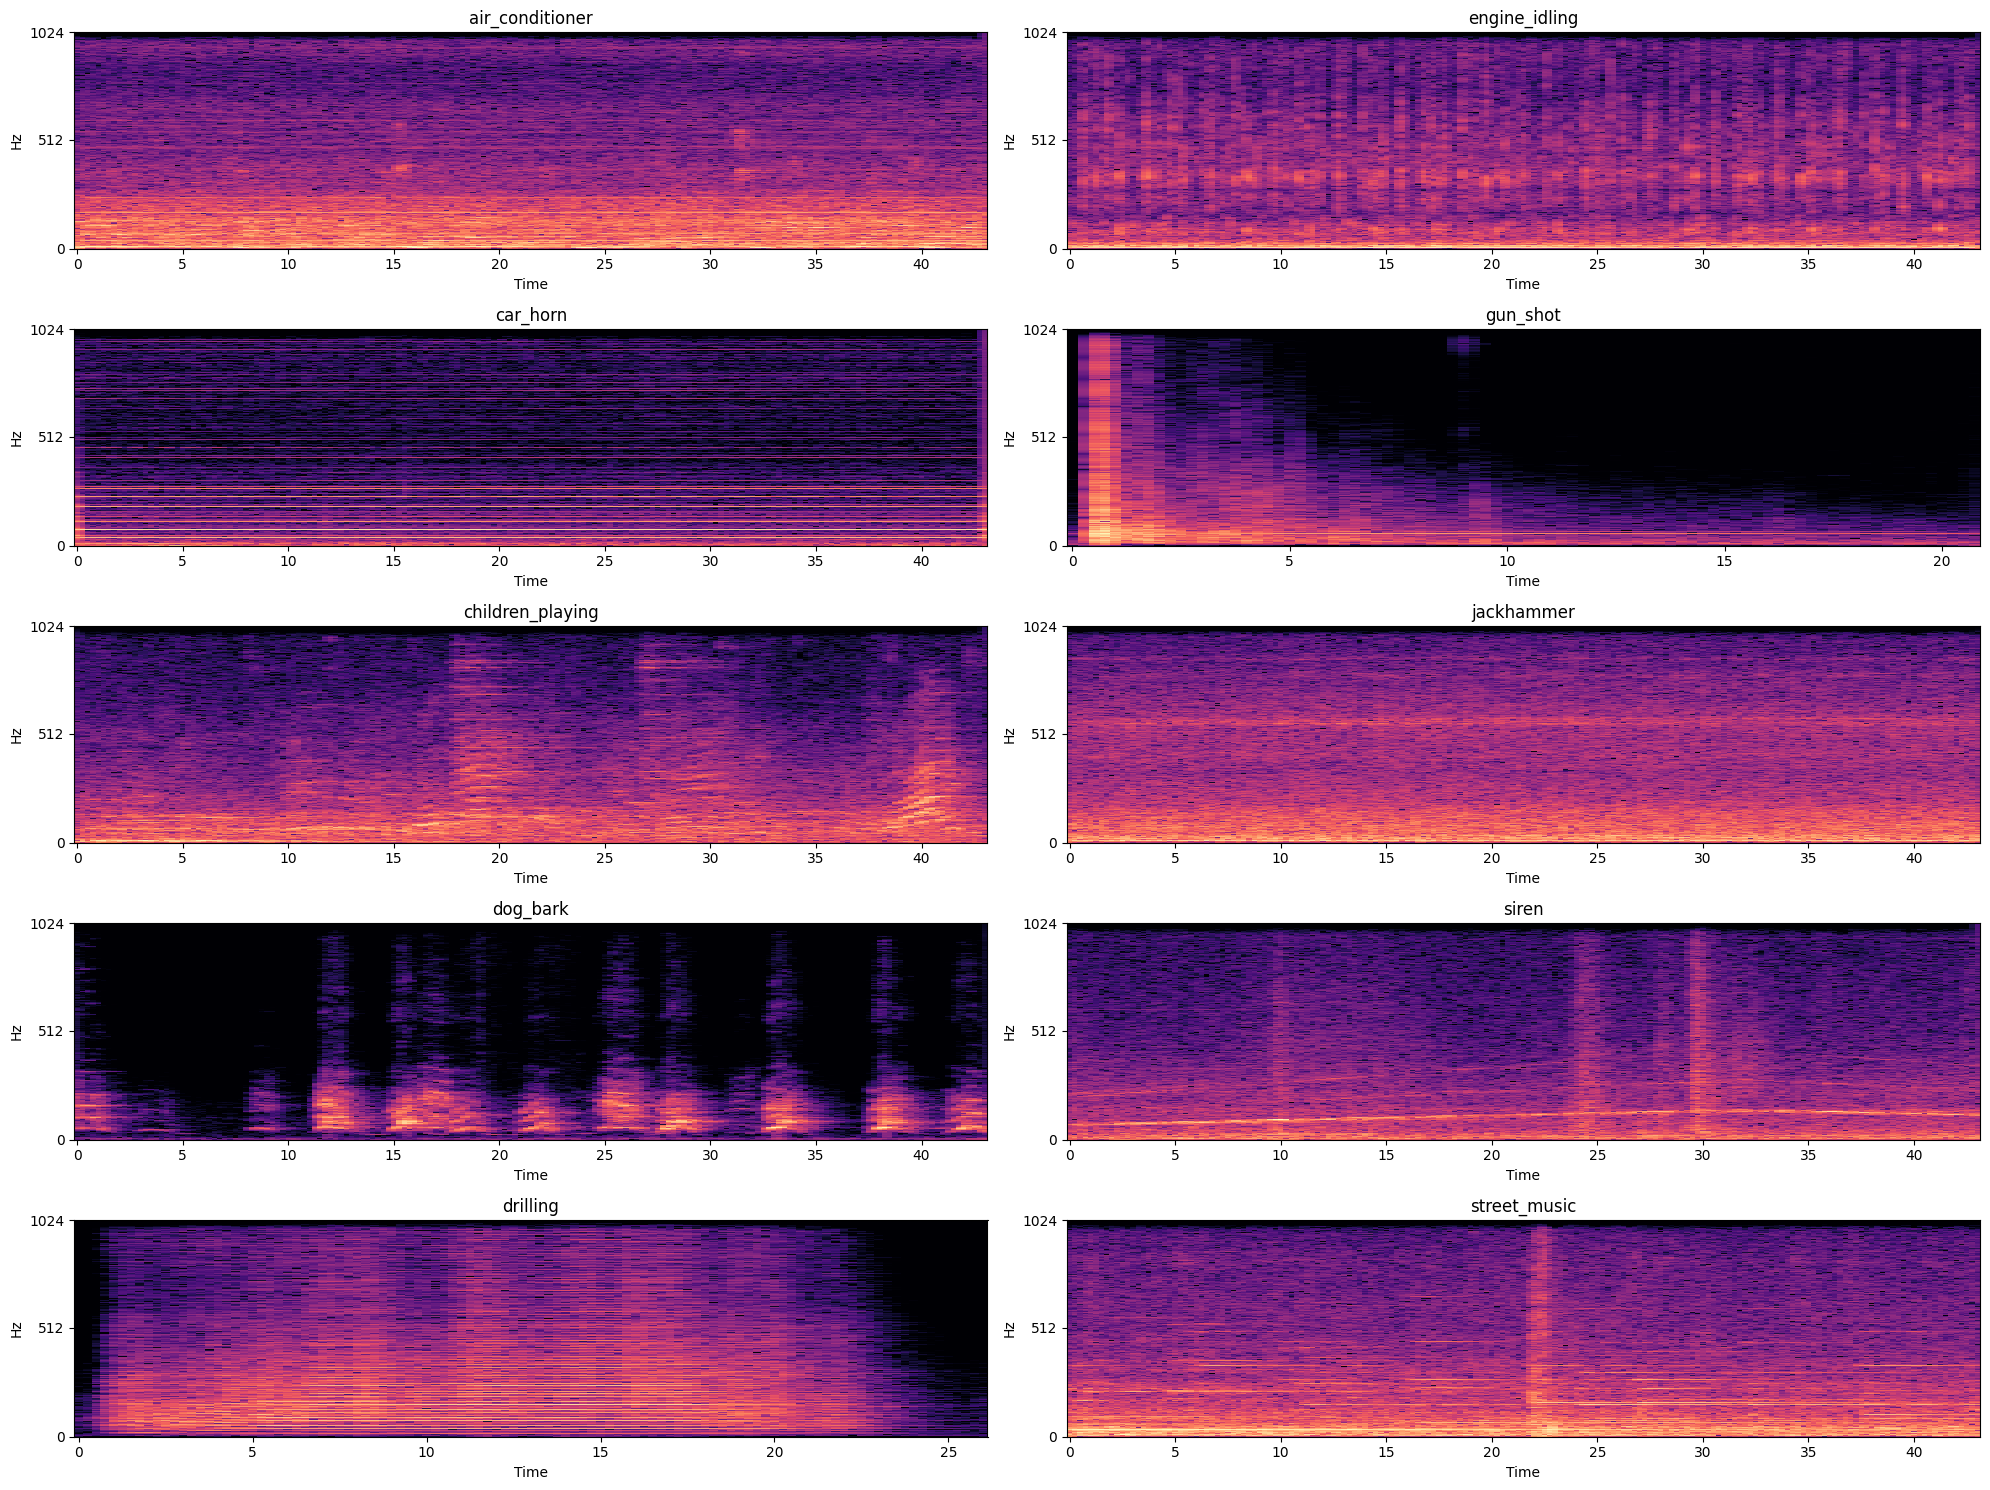

In [10]:
# Visualize the Mel-Spectograms
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,15))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(y=audio_file, n_fft=n_fft, hop_length=hop_length)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(S_db,
                             sr=n_fft,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis='mel',
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

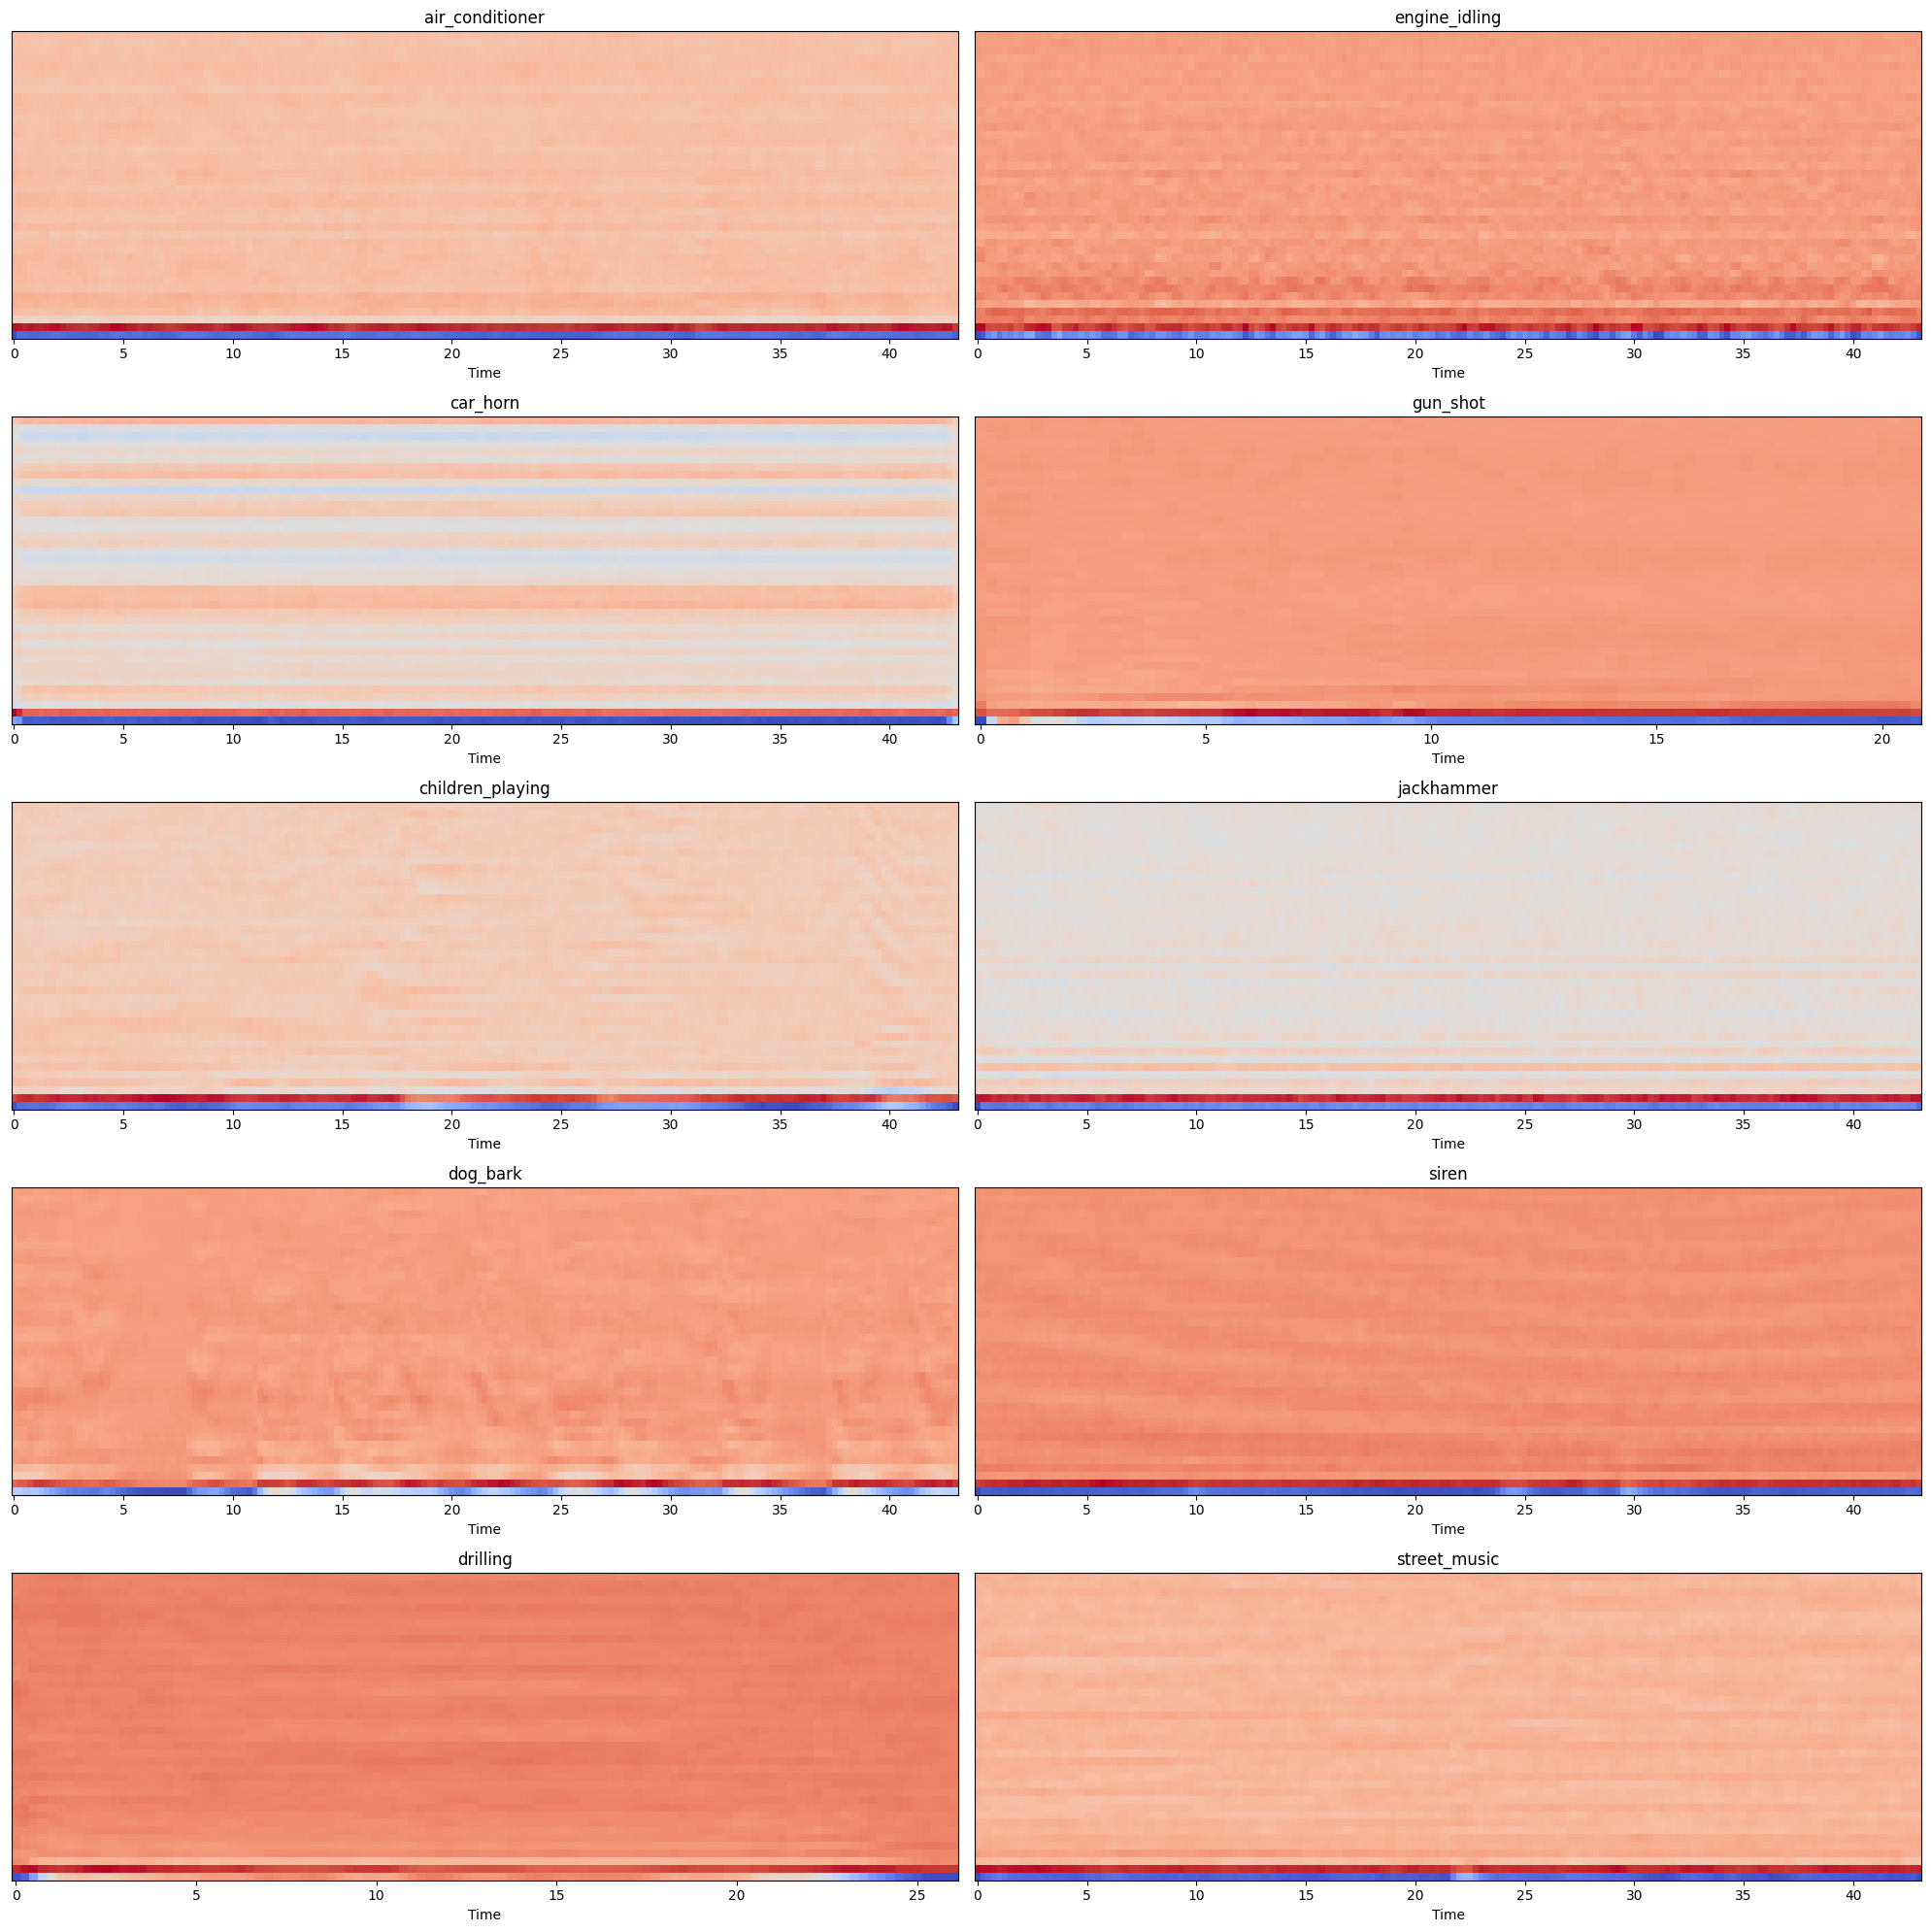

In [11]:
# Visualize 40 MFCCs
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mfccs = librosa.feature.mfcc(y=audio_file,
                                    sr=sample_rate,
                                    n_fft=n_fft,
                                    n_mfcc=40)
        librosa.display.specshow(mfccs,
                             sr=n_fft,
                             hop_length=hop_length,
                             x_axis="time",
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

In [12]:
!pip install resampy


In [13]:
# Feature extraction using librosa

def features_extract(file):
    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    # extract the features
    feature = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    feature_norm = (feature - feature.mean())/feature.std()

    # feature scaling
    scaled_feature = np.mean(feature_norm.T,axis=0)

    # return the scaled features
    return scaled_feature

# list containg all the features
extracted = []

# for each row in the csv
for index_num,row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('UrbanSound8K/audio'),'fold'+str(row["fold"])+'/',str(row['slice_file_name']))

    # get file label
    final_class_labels = row['class']

    # extract feature
    data= features_extract(file_name)

    # store it in a list
    extracted.append([data,final_class_labels])

3555it [07:33,  5.91it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8324it [16:48, 13.96it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
8329it [16:49, 21.29it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [17:33,  8.29it/s]


In [14]:
df_extracted = pd.DataFrame(extracted,columns=['feature','label'])

# Adding 'fold' column to new DataFrame which contains extracted feature and label
df_extracted['fold'] = df['fold']
df_extracted.head()

,feature,label,fold
0,"[-4.3759913, 1.7047325, -2.537049, -0.90675354...",dog_bark,5
1,"[-5.894206, 1.623344, -0.6633281, 0.94018996, ...",children_playing,5
2,"[-5.9398065, 1.6801343, -0.5251044, 0.7689586,...",children_playing,5
3,"[-5.9273343, 1.5716913, -0.42236972, 0.8643918...",children_playing,5
4,"[-5.929188, 1.610513, -0.6244964, 0.8921433, 0...",children_playing,5


In [15]:
le = LabelEncoder()
y = np.array(df_extracted.label.tolist())

filter_size = 3
y = np_utils.to_categorical(le.fit_transform(y))

num_labels = y.shape[1]

# build model
model = Sequential()
model.add(Dense(512, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               20992     
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [16]:
predicted = []
actual = []

# Taking 1 fold for Validation and rest 9 folds for train sets.
# Using for loop so that each fold becomes validation set once and rest 9 as train set.

for i in range(1,11):
    validation_data = df_extracted[df_extracted['fold'] == i]
    train_data = df_extracted[df_extracted['fold'] != i]

    x = np.array(train_data.feature.tolist())
    y = np.array(train_data.label.tolist())

    x_val = np.array(validation_data.feature.tolist())
    y_val = np.array(validation_data.label.tolist())

    y = np_utils.to_categorical(le.fit_transform(y))
    y_val = np_utils.to_categorical(le.fit_transform(y_val))

    fitting = model.fit(x, y, batch_size=64, epochs=10, validation_data=(x_val, y_val), shuffle=False)
    pred = model.predict(x_val)

    predicted.append(pred)
    actual.append(y_val)

Epoch 1/10
123/123 [==============================] - 3s 10ms/step - loss: 2.2390 - accuracy: 0.2072 - val_loss: 1.9480 - val_accuracy: 0.2784
Epoch 2/10
123/123 [==============================] - 2s 13ms/step - loss: 1.9538 - accuracy: 0.2821 - val_loss: 1.8745 - val_accuracy: 0.3482
Epoch 3/10
123/123 [==============================] - 2s 16ms/step - loss: 1.8117 - accuracy: 0.3425 - val_loss: 1.7421 - val_accuracy: 0.4066
Epoch 4/10
123/123 [==============================] - 2s 15ms/step - loss: 1.7102 - accuracy: 0.3850 - val_loss: 1.7302 - val_accuracy: 0.4158
Epoch 5/10
123/123 [==============================] - 2s 14ms/step - loss: 1.6277 - accuracy: 0.4093 - val_loss: 1.7006 - val_accuracy: 0.4181
Epoch 6/10
123/123 [==============================] - 2s 17ms/step - loss: 1.5589 - accuracy: 0.4349 - val_loss: 1.7618 - val_accuracy: 0.4422
Epoch 7/10
123/123 [==============================] - 2s 16ms/step - loss: 1.5129 - accuracy: 0.4516 - val_loss: 1.8031 - val_accuracy: 0.4616

In [17]:
acc = []
for i in range(0,10):
    predict_conv = np.argmax(predicted[i],axis=1)
    actual_conv = np.argmax(actual[i],axis=1)
    acc.append(accuracy_score(actual_conv,predict_conv))
print("Accuracy for 10 fold cross validation:",np.mean(acc))

Accuracy for 10 fold cross validation: 0.7409683837698535


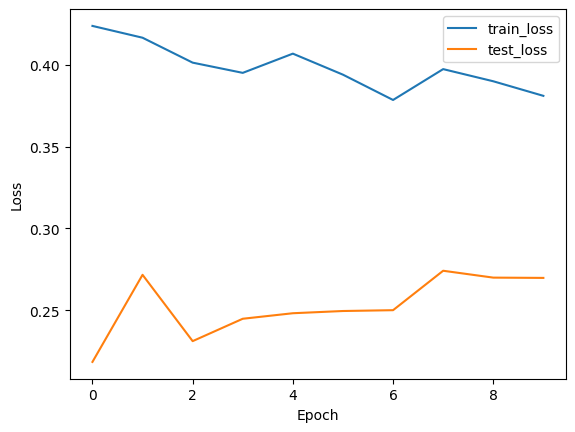

In [18]:
# Plotting ANN Loss

metrics = fitting.history
plt.plot(fitting.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

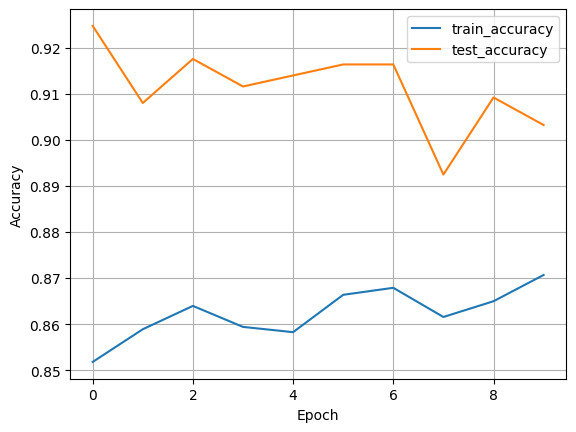

In [19]:
# Plotting ANN Accuracy

plt.plot(fitting.history['accuracy'], label='train_accuracy')
plt.plot(fitting.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)